<a href="https://colab.research.google.com/github/semkud/nnmethods/blob/main/homework3/nnmethods3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install torch
!pip install nltk
!pip install tqdm
!pip install seaborn
!pip install numpy
!pip install sklearn
import pandas as pd
import numpy as np
import torch

In [2]:
data = pd.read_csv('Fake.csv')

In [3]:
data

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [4]:
data.subject.value_counts() * 100 / data.shape[0]

News               38.541800
politics           29.134194
left-news          18.989822
Government News     6.686257
US_News             3.334611
Middle-east         3.313317
Name: subject, dtype: float64

Отлично, будем сортировать новости по категориям, причем самая большая категория называется "просто новости". Ничего хорошего можно не ожидать..

In [5]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

--2021-12-29 16:52:30--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  37.0MB/s    in 35s     

2021-12-29 16:53:06 (35.9 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [6]:
!gzip -d cc.en.300.vec.gz

In [7]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm
import string
def process_text(text):
    nopunkt = text.lower().translate(str.maketrans('', '', string.punctuation))
    words = wordpunct_tokenize(nopunkt)
    
    return words

In [8]:
word2freq = {}
lengths = []

for text in tqdm(data.text):
    
    words = process_text(text)
    
    lengths.append(len(words))
    
    for word in words:
        
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

100%|██████████| 23481/23481 [00:06<00:00, 3634.66it/s]


In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


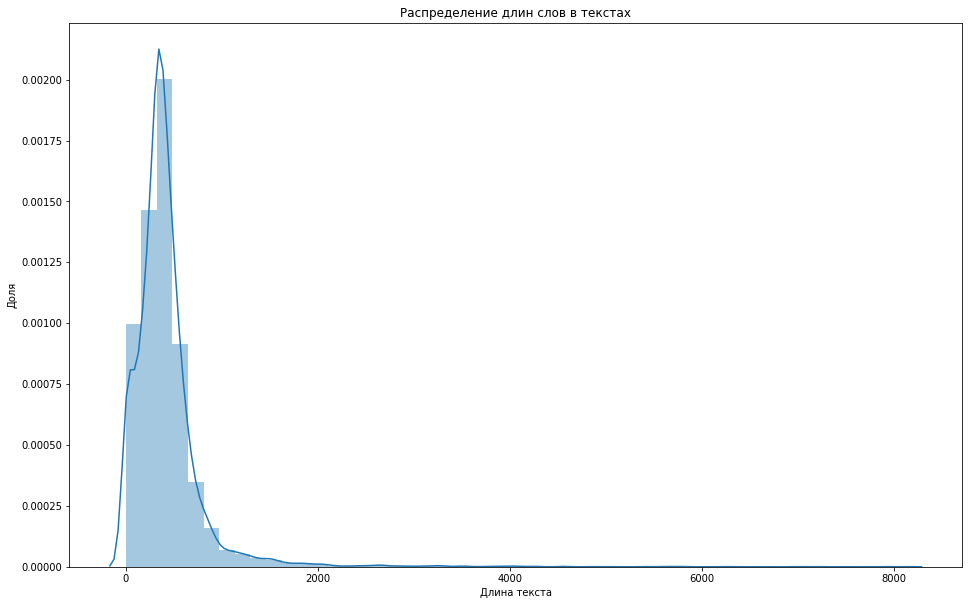

In [10]:
plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина текста')
plt.ylabel('Доля')
sns.distplot(lengths)

In [11]:
upper_threshold = 70 #128, 256
lower_threshold = 1

correct_percent = len([sent_len for sent_len in lengths 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(lengths)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'6.70 % наших текстов входят в промежуток от 1 до 70 слов'

Тексты новостей очень длинные. Как надо было бы сделать: разбить каждую новость на массивы по 64 слова, для каждого массива предсказать вероятности попаданий в разные классы, затем взять среднее и получить итоговую вероятность для текста.
Мы пойдем более простым путем - просто обрежем все новости по 70 (или больше - поэкспериментируем) слов, потому что по первым 70 словам, а это где-то 6 предложений, вполне можно предсказать категорию новости

In [12]:
len(word2freq)

186879

In [13]:
'{} слов, которые встречались 3 и менее раз'.format(len([word for word in word2freq if word2freq[word] <=3]))
'{} слов, которые встречались 1 и менее раз'.format(len([word for word in word2freq if word2freq[word] <=1]))

'82178 слов, которые встречались 1 и менее раз'

Почти половина слов встречается только в каком-то одном тексте..

In [14]:
word2index = {'PAD': 0}
vectors = []
    
word2vec_file = open('cc.en.300.vec')

n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc='Read word2vec', total=n_words)

while True:

    line = word2vec_file.readline().strip()

    if not line:
        break
        
    current_parts = line.split()

    current_word = ' '.join(current_parts[:-embedding_dim])

    if current_word in word2freq:

        word2index[current_word] = len(word2index)

        current_vectors = current_parts[-embedding_dim:]
        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)

    progress_bar.update(1)

progress_bar.close()

word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec: 100%|██████████| 2000000/2000000 [01:00<00:00, 33272.54it/s]


In [15]:
len(word2index)

61142

In [16]:
unk_words = [word for word in word2freq if word not in word2index]
unk_counts = [word2freq[word] for word in unk_words]
n_unk = sum(unk_counts) * 100 / sum(list(word2freq.values()))

sub_sample_unk_words = {word: word2freq[word] for word in unk_words}
sorted_unk_words = list(sorted(sub_sample_unk_words, key=lambda x: sub_sample_unk_words[x], reverse=True))

print('Мы не знаем {:.2f} % слов в датасете'.format(n_unk))
print('Количество неизвестных слов {} из {}, то есть {:.2f} % уникальных слов в словаре'.format(
    len(unk_words), len(word2freq), len(unk_words) * 100 / len(word2freq)))
print('В среднем каждое встречается {:.2f} раз'.format(np.mean(unk_counts)))
print()
print('Топ 5 невошедших слов:')

for i in range(5):
    print(sorted_unk_words[i], 'с количеством вхождениий -', word2freq[sorted_unk_words[i]])

Мы не знаем 2.94 % слов в датасете
Количество неизвестных слов 125738 из 186879, то есть 67.28 % уникальных слов в словаре
В среднем каждое встречается 2.32 раз

Топ 5 невошедших слов:
2017realdonaldtrump с количеством вхождениий - 1221
presidentelect с количеством вхождениий - 794
21wiretv с количеством вхождениий - 783
antitrump с количеством вхождениий - 728
filessupport с количеством вхождениий - 594


Прикольно! Половина слов встречается по одному разу, и 2/3 всех слов мы не знаем

Сетка


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader


In [18]:
cat_mapper = {cat: n for n, cat in enumerate(data.subject.unique())}


In [19]:
cat_mapper

{'Government News': 2,
 'Middle-east': 5,
 'News': 0,
 'US_News': 4,
 'left-news': 3,
 'politics': 1}

In [20]:
data.subject = data.subject.map(cat_mapper)

In [21]:
import re


In [22]:
class WordData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, sequence_length=70, pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = y_data
        
        self.word2index = word2index
        self.sequence_length = sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.load(x_data, verbose=verbose)
        
    @staticmethod
    def process_text(text):
        nopunkt = text.lower().translate(str.maketrans('', '', string.punctuation))
        words = wordpunct_tokenize(nopunkt)
        return words
        
    def load(self, data, verbose=True):
        
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        
        for text in data_iterator:            
            words = self.process_text(text)
            
            indexed_words = self.indexing(words)
            
            self.x_data.append(indexed_words)
    
    def indexing(self, tokenized_text):

        # здесь мы не используем токен UNK, потому что мы его специально не учили
        # становится непонятно какой же эмбеддинг присвоить неизвестному слову,
        # поэтому просто выбрасываем наши неизветсные слова
        
        return [self.word2index[word] for word in tokenized_text if word in self.word2index]
    
    def padding(self, sequence):
        
        # Ограничить длину self.sequence_length
        # если длина меньше максимально - западить
        if len(sequence)< self.sequence_length:
          add_pad = self.sequence_length - len(sequence)
          return sequence+[self.pad_index]*add_pad
        else:
          return sequence[:self.sequence_length]
    
    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        
        y = self.y_data[idx]
        
        return x, y

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

x_train, x_validation, y_train, y_validation = train_test_split(data.text, data.subject, test_size=0.1)

train_dataset = WordData(list(x_train), list(y_train), word2index)
train_loader = DataLoader(train_dataset, batch_size=64)

validation_dataset = WordData(list(x_validation), list(y_validation), word2index)
validation_loader = DataLoader(validation_dataset, batch_size=64)



Loading data: 100%|██████████| 2349/2349 [00:01<00:00, 1726.32it/s]


In [57]:
pp = torch.randn(64,64,66)

In [62]:
ppp = torch.narrow(pp, 2, 0, 64)
print(ppp.shape)

torch.Size([64, 64, 64])


In [147]:
from math import sqrt

class model_with_att(torch.nn.Module):
  def __init__(self, matrix_w, n=len(cat_mapper)): #n - количетсво категорий
        
        super().__init__()

        self.n = n

        self.emb_layer = torch.nn.Embedding.from_pretrained(torch.Tensor(matrix_w))

        self.LSTM = torch.nn.LSTM(198, 5, num_layers=2, dropout=0.2, bidirectional=False)
        
        self.cnn_3gr = torch.nn.Conv1d(in_channels=300, out_channels=64, kernel_size=(3,), stride=(1,))# три конволюционных фильтра с разными ядрами (3,4,5) чтобы были всякие нграммы ловить
        self.cnn_4gr = torch.nn.Conv1d(in_channels=300, out_channels=64, kernel_size=(4,), stride=(1,))
        self.cnn_5gr = torch.nn.Conv1d(in_channels=300, out_channels=64, kernel_size=(5,), stride=(1,))
        self.mylinear = torch.nn.Linear(320, 5) # не понимаю.... 
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.functional.softmax
        self.argmax = torch.argmax
  def forward(self, x):
      x_emb = self.emb_layer(x) #примените эмбеддинги
      x_emb = x_emb.transpose(1, 2)
      x_cnn3 = torch.narrow(self.relu(self.cnn_3gr(x_emb)), 2, 0, 66)
      x_cnn4 = torch.narrow(self.relu(self.cnn_4gr(x_emb)), 2, 0, 66)
      x_cnn5 = self.relu(self.cnn_5gr(x_emb))
      x_cat = torch.cat((x_cnn3, x_cnn4, x_cnn5), dim=-1)
      print('ok1')
      #print(x_cat.shape)
      x_cat = x_cat.transpose(0, 1)
      print('ok2')
      print(x_cat.shape)
      x, _ = self.LSTM(x_cat)
      print(x.shape)
      x = x.transpose(0, 1)
      print('ok3')
      print(x.shape)
      #не понимаю, у нас же выход с лстм должен уже быть батч х число категорий..
      #Куда девать еще одну размерность??? Ну давайте еще один линейный слой
      x = x.reshape(x.shape[0], -1)
      print('ok4')
      print(x.shape)
      x = self.mylinear(x)
      print('ok5')
      print(x.shape)
      return x.float()


In [122]:
n_classes = data.subject.unique().shape[0]

In [148]:
model = model_with_att(vectors, n_classes)

In [149]:
model

model_with_att(
  (emb_layer): Embedding(61142, 300)
  (LSTM): LSTM(198, 5, num_layers=2, dropout=0.2)
  (cnn_3gr): Conv1d(300, 64, kernel_size=(3,), stride=(1,))
  (cnn_4gr): Conv1d(300, 64, kernel_size=(4,), stride=(1,))
  (cnn_5gr): Conv1d(300, 64, kernel_size=(5,), stride=(1,))
  (mylinear): Linear(in_features=320, out_features=5, bias=True)
  (relu): ReLU()
)

In [150]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [151]:
print(device)

cuda


In [152]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [154]:
epochs = 5
losses = []
best_test_loss = 10.

test_f1 = []

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_targets = []
    test_pred_class = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    model.train()
    
    for x, y in train_loader:
        print('look!')
        print(x.shape)
        print(y.shape)
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    model.eval()
    
    for x, y in validation_loader:
        
        x = x.to(device)

        with torch.no_grad():

            pred = model(x)

            pred = pred.cpu()

            test_targets.append(y.numpy())
            test_pred_class.append(np.argmax(pred, axis=1))

            loss = criterion(pred, y)

            test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)

    test_targets = np.concatenate(test_targets).squeeze()
    test_pred_class = np.concatenate(test_pred_class).squeeze()

    f1 = f1_score(test_targets, test_pred_class, average='micro')

    test_f1.append(f1)
    
    print()
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    print('F1 test - {:.3f}'.format(f1))
        
    # Early stopping:
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break


Epoch 1:   0%|          | 0/21132 [00:00<?, ?it/s]

look!
torch.Size([64, 70])
torch.Size([64])
ok1
ok2
torch.Size([64, 64, 198])
torch.Size([64, 64, 5])
ok3
torch.Size([64, 64, 5])
ok4
torch.Size([64, 320])
ok5
torch.Size([64, 5])


RuntimeError: ignored

Epoch 1:   0%|          | 0/21132 [00:23<?, ?it/s]


Эх, короче так и не запустилось. Объясните, пожалуйста, почему, и что я делал не так.

Статью я прочитал. Из описанных экспериментов там только число и вид фильтров в сверточной сети, остальные параметры указаны точно, упомянуто, что к некоторым пришли в ходе экспериментов.

Соответственно, видимо, надо было повторить рассчеты с вот этими семью вариантами фильтров (2, 3, 4, 23, 24, 34, 234), и в начале дать возможность задать LEN и dropout в LSTM переменными.